# Clinical Symptom Analysis - MST

Do spectral features relate to clinical symptom changes after MST treatment? Do these features resemble the changes seen in ECT, a more invasive seizure therapy? In this notebook, we use an existing dataset shared with us by Hill, et al 2020 of pre- and post-treatment resting state EEG data from 23 patients receiving a standard therapeutic course of MST as a treatment for Major Depressive Disorder. 

Using spectral parameterization, we quantified aperiodic exponent, offest, as well as features of oscillatory peaks (when present) in the delta (1-4 Hz), theta (4-7 Hz), and alpha (7-14 Hz) frequency ranges. Here, we attempt to relate these features to a standard measure of clinical symptom severity, the Hamilton Depression Rating Scale (HAMD/HDRS), and a standard measure of cognitive wellbeing, the Montreal Cognitive Assessment (MoCA). Specifically, we focus on how spectral features like aperiodic activity and offset might better capture changes in depressive symptom improvement and cognitive wellbeing as an effect of MST.

In [5]:
import numpy as np
import scipy.io as sio
import pandas as pd
import h5py as h5

import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.formula.api import ols
from pingouin import corr, ttest

In [6]:
MST_clinical = pd.read_csv('../saved_files/mst_files/mst_clinical_data/MST_clinical.csv')
MST_HAMD = pd.read_csv('../saved_files/mst_files/mst_clinical_data/MST_HAMD.csv')
MST_MOCA = pd.read_csv('../saved_files/mst_files/mst_clinical_data/MST_MOCA.csv')
exp_df = pd.read_csv('../saved_files_appeal/mst_files/mst_all_features.csv', index_col = 0)


In [7]:
exp_df

,patient,pre_post,channel,delta_cf,delta_bw,delta_amp,delta_bp,theta_cf,theta_bw,theta_amp,theta_bp,alpha_cf,alpha_bw,alpha_amp,alpha_bp,offset,exponent,error,r_squared,exclude
0,9,pre,FP1,NaN,NaN,NaN,-11.283243,6.160561,3.012282,0.722517,-11.315310,9.540913,2.163893,1.129194,-11.300131,-10.910216,1.385597,0.068730,0.981048,False
1,9,pre,FPZ,NaN,NaN,NaN,-11.311451,6.265365,3.086557,0.733975,-11.328971,9.583599,2.081748,1.151045,-11.294941,-10.944674,1.359475,0.069224,0.980534,False
2,9,pre,FP2,NaN,NaN,NaN,-11.285025,NaN,NaN,NaN,-11.403185,8.828444,5.516757,0.979455,-11.320865,-10.902679,1.417495,0.073972,0.978797,False
3,9,pre,AF3,NaN,NaN,NaN,-11.235786,NaN,NaN,NaN,-11.160861,10.032387,8.000000,0.986879,-11.267972,-10.919900,1.315336,0.129817,0.947035,False
4,9,pre,AF4,NaN,NaN,NaN,-11.277961,5.176093,1.263650,0.715413,-11.283006,8.727501,4.945225,0.997578,-11.301249,-10.889718,1.419578,0.071667,0.979583,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2755,191,post,PO6,NaN,NaN,NaN,-11.774113,6.139891,3.100660,0.467476,-11.828470,8.800853,1.814433,1.723120,-11.188669,-11.364319,1.234819,0.066362,0.987620,False
2756,191,post,PO8,NaN,NaN,NaN,-11.771589,NaN,NaN,NaN,-11.868800,9.042060,3.424618,1.501029,-11.254407,-11.341603,1.255972,0.104854,0.968433,False
2757,191,post,O1,NaN,NaN,NaN,-11.757973,4.199002,1.516109,0.395459,-11.809631,8.773147,1.088419,1.721570,-11.278803,-11.430549,1.197102,0.060777,0.987291,False
2758,191,post,OZ,NaN,NaN,NaN,-11.736114,5.705399,1.000000,0.412440,-11.817168,8.694386,1.008885,1.629046,-11.328935,-11.264617,1.344792,0.057019,0.990354,False


In [3]:
MST_clinical

,SubjectID,filt,DROPOUTS,AgeAtEnrollment,Education,Education_years_,Sex,x_OfAcuteTxsReceived,StimFreq,AgeAtOnset,Diagnosis,EpisodeType,Severity,x_OfEpisodes,DurationOfCurrentEpisode_wks,Comorbidity,AxisIIDiagnoses,Comments
0,9,1,0,47,'Graduate/Professional School',20,'F',24,100,13.0,'MDD',"'Recurrent, neither type'",'Moderate',6.0,250,'none','none',''
1,10,1,0,53,'Graduate/Professional School',20,'M',18,100,34.0,'MDD',"'Recurrent, neither type'",'Severe w/o psychotic features',16.0,10,'none','none',''
2,18,1,0,28,'grade 7 to 12 (w/o graduating high school)',11,'M',24,100,16.0,'MDD',"'Single Episode, Neither type'",'Moderate',1.0,624,'none','none',''
3,20,1,0,46,'2yr College',14,'F',18,100,41.0,'MDD',"'Recurrent, Melancholic'",'Moderate',2.0,243,'none','none',''
4,22,1,1,35,'Grade 7 to 12 (without graduating high school)',11,'M',6,100,30.0,'MDD',"'Single, Neither type'",'Moderate',1.0,250,'Panic disorder','none',''
5,25,1,0,49,'Grade 12',12,'M',21,100,22.0,'MDD',"'Recurrent, neither type'",'Moderate',NaN,8,'none','none',''
6,33,1,0,28,'Graduate/Professional School',20,'F',24,100,23.0,'MDD',"'Recurrent, neither type'","'Severe, without psychotic features'",6.0,7,'none','none',''
7,35,1,0,38,'2yr College',14,'F',6,100,28.0,'MDD',"'Recurrent, Melancholic'",'Moderate',3.0,312,'Panic disorder?','none',''
8,37,1,0,22,'Part College',12,'M',23,100,21.0,'MDD',"'Single, Neither type'",'Moderate',1.0,96,'none','none',''
9,40,1,0,58,'Grade 12',12,'F',24,100,9.0,'MDD',"'Recurrent, Melancholic'","'Severe, without psychotic features'",NaN,450,'Panic Disorder with Agoraphobia','none',''


# 0. Check all clinical ratings for consistency/validity

Data cleaning

In [4]:
MST_HAMD.columns

Index(['subject', 'filt', 'DROPOUTS', 'diffT12_LOCF', 'LOCF_responders',
       'responders', 'remitters1', 'remitters2', 'LOCF_remitters2',
       'diff_LOCF', 'diff', 'ratio_LOCF', 'ratio', 'SuicideBaseline',
       'TotalBaseline', 'SuicideT3', 'TotalT3', 'SuicideT6', 'TotalT6',
       'SuicideT9', 'TotalT9', 'SuicideT12', 'TotalT12', 'SuicideT15',
       'TotalT15', 'SuicideT18', 'TotalT18', 'SuicideT21', 'TotalT21',
       'SuicidePost', 'TotalPost', 'SuicideT3_LOCF', 'TotalT3_LOCF',
       'SuicideT6_LOCF', 'TotalT6_LOCF', 'SuicideT9_LOCF', 'TotalT9_LOCF',
       'SuicideT12_LOCF', 'TotalT12_LOCF', 'SuicideT15_LOCF', 'TotalT15_LOCF',
       'SuicideT18_LOCF', 'TotalT18_LOCF', 'SuicideT21_LOCF', 'Total21_LOCF',
       'SuicidePost_LOCF', 'TotalPost_LOCF'],
      dtype='object')

In [5]:
# rename columns

MST_HAMD = MST_HAMD[['subject', 'TotalBaseline', 'TotalPost']].copy().rename(columns={'subject': 'patient',
                                                                                 'TotalBaseline': 'HAMD_TotalPre',
                                                                                 'TotalPost': 'HAMD_TotalPost'})
# MST_MOCA = MST_MOCA[['subject', 'TotalPre', 'TotalPost']].copy().rename(columns={'subject': 'patient',
#                                                                                    'TotalPre': 'MADRS_TotalPre',
#                                                                                    'TotalPost': 'MADRS_TotalPost'})

# merge into single dataframe
# all_clinical = pd.merge(ECT_HAMD, ECT_MADRS, on='patient', how='outer')

In [6]:
MST_clinical[['SubjectID','x_OfAcuteTxsReceived']]

,SubjectID,x_OfAcuteTxsReceived
0,9,24
1,10,18
2,18,24
3,20,18
4,22,6
5,25,21
6,33,24
7,35,6
8,37,23
9,40,24


In [7]:
# rename columns
MST_clinical = MST_clinical[['SubjectID','x_OfAcuteTxsReceived']].copy().rename(columns={'SubjectID': 'patient',
                                                                                 'x_OfAcuteTxsReceived': 'n_TxsReceived'})
# merge into single dataframe
all_clinical = pd.merge(MST_HAMD, MST_clinical, on='patient', how='outer')

In [8]:
all_clinical

,patient,HAMD_TotalPre,HAMD_TotalPost,n_TxsReceived
0,9,23,19.0,24
1,10,28,NaN,18
2,18,24,27.0,24
3,20,27,NaN,18
4,22,22,NaN,6
5,25,34,NaN,21
6,33,26,19.0,24
7,35,29,NaN,6
8,37,21,11.0,23
9,40,24,11.0,24


### 0.1 calculating Symptom differences and improvement ratios

*Difference = pre - post*  
Difference captures absolute change in depression severity.


*Ratio = (pre - post) / pre*   
Ratio captures relative change in depression severity compared to baseline.

In [9]:
all_clinical['HAMD_diff'] = all_clinical['HAMD_TotalPre'] - all_clinical['HAMD_TotalPost']
all_clinical['HAMD_ratio'] = (all_clinical['HAMD_TotalPre'] - all_clinical['HAMD_TotalPost'])/all_clinical['HAMD_TotalPre']


In [10]:
all_clinical

,patient,HAMD_TotalPre,HAMD_TotalPost,n_TxsReceived,HAMD_diff,HAMD_ratio
0,9,23,19.0,24,4.0,0.173913
1,10,28,NaN,18,NaN,NaN
2,18,24,27.0,24,-3.0,-0.125000
3,20,27,NaN,18,NaN,NaN
4,22,22,NaN,6,NaN,NaN
5,25,34,NaN,21,NaN,NaN
6,33,26,19.0,24,7.0,0.269231
7,35,29,NaN,6,NaN,NaN
8,37,21,11.0,23,10.0,0.476190
9,40,24,11.0,24,13.0,0.541667


## 1. All electrode analysis

What is the relationship between the changes in EEG features pre/post treatment and clinical symptom improvement? What can the average features across all 60 EEG electrodes tell us about clinical symptom changes?

In [11]:
# features to include in analysis
features = ['delta_cf', 'delta_bw', 'delta_amp', 'delta_bp', 'theta_cf', 'theta_bw', 'theta_amp',
            'theta_bp', 'alpha_cf', 'alpha_bw', 'alpha_amp', 'alpha_bp', 'offset', 'exponent']

# exclude bad fits
exp_df_included = exp_df[exp_df['exclude']==False]

# average across ALL electrodes
exp_df_mean = pd.DataFrame(exp_df_included.groupby(['patient', 'pre_post'], as_index=False)[features].mean())

# Pre/Post Difference dataframe
eeg_diff_df_mean = exp_df_mean.groupby(['patient'], as_index=False)[features].diff().dropna(0,how='all')
eeg_diff_df_mean['patient'] = exp_df_mean['patient']

/var/folders/96/g2_ml18s7v1cqm0wh8_8n5bh0000gn/T/ipykernel_6067/50583058.py:12: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only
  eeg_diff_df_mean = exp_df_mean.groupby(['patient'], as_index=False)[features].diff().dropna(0,how='all')


In [12]:
eeg_diff_df_mean.head()

,delta_cf,delta_bw,delta_amp,delta_bp,theta_cf,theta_bw,theta_amp,theta_bp,alpha_cf,alpha_bw,alpha_amp,alpha_bp,offset,exponent,patient
1,NaN,NaN,NaN,0.434978,-0.261639,0.171978,-0.126412,0.217771,-0.192200,1.119524,-0.033322,0.237228,0.507025,0.345650,9
3,1.442773,-0.453134,-0.500677,0.253834,NaN,NaN,NaN,0.271554,-0.243517,0.389320,0.133247,0.377337,0.261876,0.025480,10
5,1.732426,0.000000,-0.139468,-0.026524,-1.167935,-0.769745,-0.142296,0.134673,-0.024780,0.562352,0.012112,-0.016471,0.042335,0.115917,18
7,NaN,NaN,NaN,-0.379509,0.208337,-0.702715,-0.236117,-0.450002,0.006089,-1.981499,0.285625,-0.103030,-0.369752,-0.184502,22
9,NaN,NaN,NaN,0.494483,1.483624,-0.105379,0.107728,0.323614,-0.800650,-0.613174,-0.779568,-0.284728,0.466595,0.014182,25


In [13]:
all_clinical

,patient,HAMD_TotalPre,HAMD_TotalPost,n_TxsReceived,HAMD_diff,HAMD_ratio
0,9,23,19.0,24,4.0,0.173913
1,10,28,NaN,18,NaN,NaN
2,18,24,27.0,24,-3.0,-0.125000
3,20,27,NaN,18,NaN,NaN
4,22,22,NaN,6,NaN,NaN
5,25,34,NaN,21,NaN,NaN
6,33,26,19.0,24,7.0,0.269231
7,35,29,NaN,6,NaN,NaN
8,37,21,11.0,23,10.0,0.476190
9,40,24,11.0,24,13.0,0.541667


In [14]:
clin_eeg_diff_df = pd.merge(all_clinical, eeg_diff_df_mean, on='patient', how='outer')
#clin_eeg_diff_df.drop([7,8]) # remove patients with incorrectly input MADRS data

In [15]:
clin_eeg_diff_df

,patient,HAMD_TotalPre,HAMD_TotalPost,n_TxsReceived,HAMD_diff,HAMD_ratio,delta_cf,delta_bw,delta_amp,delta_bp,theta_cf,theta_bw,theta_amp,theta_bp,alpha_cf,alpha_bw,alpha_amp,alpha_bp,offset,exponent
0,9,23,19.0,24,4.0,0.173913,NaN,NaN,NaN,0.434978,-0.261639,0.171978,-0.126412,0.217771,-0.192200,1.119524,-0.033322,0.237228,0.507025,0.345650
1,10,28,NaN,18,NaN,NaN,1.442773,-4.531343e-01,-0.500677,0.253834,NaN,NaN,NaN,0.271554,-0.243517,0.389320,0.133247,0.377337,0.261876,0.025480
2,18,24,27.0,24,-3.0,-0.125000,1.732426,0.000000e+00,-0.139468,-0.026524,-1.167935,-0.769745,-0.142296,0.134673,-0.024780,0.562352,0.012112,-0.016471,0.042335,0.115917
3,20,27,NaN,18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,22,22,NaN,6,NaN,NaN,NaN,NaN,NaN,-0.379509,0.208337,-0.702715,-0.236117,-0.450002,0.006089,-1.981499,0.285625,-0.103030,-0.369752,-0.184502
5,25,34,NaN,21,NaN,NaN,NaN,NaN,NaN,0.494483,1.483624,-0.105379,0.107728,0.323614,-0.800650,-0.613174,-0.779568,-0.284728,0.466595,0.014182
6,33,26,19.0,24,7.0,0.269231,NaN,NaN,NaN,-0.522628,-0.152538,-0.965983,-0.440249,-0.488498,0.058184,-0.219198,0.204019,0.044466,-0.526216,-0.494473
7,35,29,NaN,6,NaN,NaN,0.095263,-2.597532e-08,-0.082597,-0.257054,-0.376757,-0.481297,-0.370930,-0.371153,-0.089036,0.994337,0.103503,0.007112,-0.224031,-0.138135
8,37,21,11.0,23,10.0,0.476190,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,40,24,11.0,24,13.0,0.541667,NaN,NaN,NaN,-0.201802,NaN,NaN,NaN,-0.060564,-0.287408,-0.841394,-0.028574,0.017294,-0.340487,-0.356957


<AxesSubplot:>

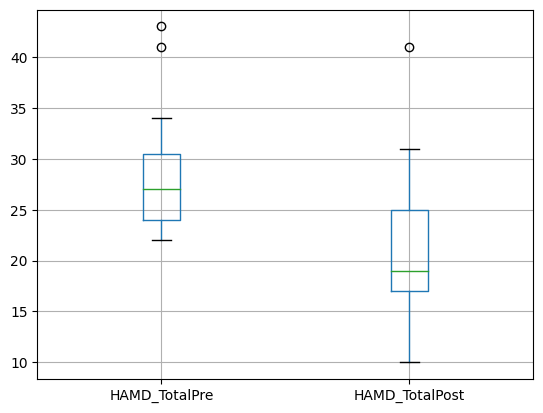

In [16]:
# boxplot of MST HAMD measures

# only MST subjects that have ECT recordings

incl_clin_eeg_diff_df = clin_eeg_diff_df[clin_eeg_diff_df['exponent'].notna()]
incl_clin_eeg_diff_df.boxplot(['HAMD_TotalPre', 'HAMD_TotalPost'])

In [17]:
ttest(incl_clin_eeg_diff_df['HAMD_TotalPre'], incl_clin_eeg_diff_df['HAMD_TotalPost'], paired=True)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,4.142088,14,two-sided,0.000997,"[3.25, 10.22]",0.925102,38.814,0.914382


### What is the relationship of the HAMD ratio to spectral features and traditional band power measures?

In [18]:
formula = 'HAMD_ratio ~ exponent + offset + delta_bp + theta_bp'

model = ols(formula, clin_eeg_diff_df).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             HAMD_ratio   R-squared:                       0.456
Model:                            OLS   Adj. R-squared:                  0.238
Method:                 Least Squares   F-statistic:                     2.094
Date:                Wed, 03 May 2023   Prob (F-statistic):              0.156
Time:                        12:54:37   Log-Likelihood:                 6.1138
No. Observations:                  15   AIC:                            -2.228
Df Residuals:                      10   BIC:                             1.313
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.2418      0.072      3.335      0.0

/Users/sydneysmith/opt/anaconda3/envs/mst-ect/lib/python3.9/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


/Users/sydneysmith/opt/anaconda3/envs/mst-ect/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='exponent', ylabel='HAMD_ratio'>

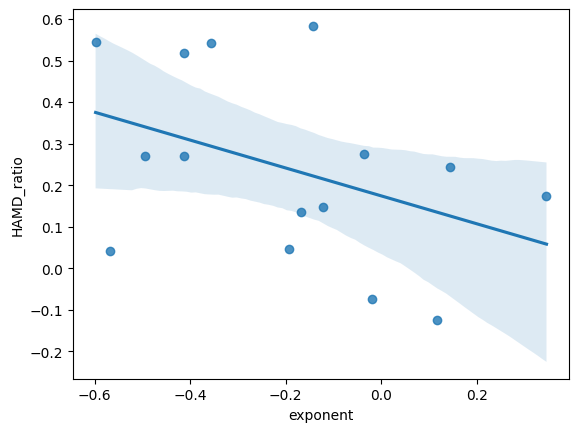

In [19]:
sns.regplot(clin_eeg_diff_df['exponent'], clin_eeg_diff_df['HAMD_ratio'])

In [20]:
corr(clin_eeg_diff_df['exponent'], clin_eeg_diff_df['HAMD_ratio'])

,n,r,CI95%,p-val,BF10,power
pearson,15,-0.413193,"[-0.76, 0.13]",0.125813,0.934,0.346773


## 2. Frontal Channels Only Analysis

If we limit the channels to only frontal and central electrodes, is there a more localized difference?

In [21]:
# features to include in analysis
features = ['delta_cf', 'delta_bw', 'delta_amp', 'delta_bp', 'theta_cf', 'theta_bw', 'theta_amp',
            'theta_bp', 'alpha_cf', 'alpha_bw', 'alpha_amp', 'alpha_bp', 'offset', 'exponent']

# exclude bad fits
exp_df_included = exp_df[exp_df['exclude']==False]

In [22]:
FRONTAL_ONLY = True
# frontal_channels = ['FP1', 'FPZ', 'FP2', 'AF3', 'AF4', 'F7', 'F5', 'F3', 'F1', 'FZ',
#                     'F2', 'F4', 'F6', 'F8', 'FT7', 'FC5', 'FC3', 'FC1', 'FCZ', 'FC2',
#                     'FC4', 'FC6', 'FT8', 'C5', 'C3', 'C1', 'CZ', 'C2', 'C4', 'C6']

frontal_channels = ['FP1', 'FPZ', 'FP2', 'AF3', 'AF4', 'F7', 'F5', 'F3', 'F1', 'FZ',
                    'F2', 'F4', 'F6', 'F8', 'FC5', 'FC3', 'FC1', 'FCZ', 'FC2',
                    'FC4', 'FC6']

if FRONTAL_ONLY:
    exp_df_included = exp_df_included[exp_df_included['channel'].isin(frontal_channels)]

In [23]:
# average across frontal electrodes
exp_df_mean = pd.DataFrame(exp_df_included.groupby(['patient', 'pre_post'], as_index=False)[features].mean())

# Pre/Post Difference dataframe
eeg_diff_df_mean = exp_df_mean.groupby(['patient'], as_index=False)[features].diff().dropna(0,how='all')
eeg_diff_df_mean['patient'] = exp_df_mean['patient']

/var/folders/96/g2_ml18s7v1cqm0wh8_8n5bh0000gn/T/ipykernel_6067/3555866108.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only
  eeg_diff_df_mean = exp_df_mean.groupby(['patient'], as_index=False)[features].diff().dropna(0,how='all')


In [24]:
clin_eeg_diff_df = pd.merge(all_clinical, eeg_diff_df_mean, on='patient', how='outer')
# clin_eeg_diff_df.drop([7,8])

In [25]:
formula = 'HAMD_ratio ~ exponent + offset + delta_bp + theta_bp + theta_amp'

model = ols(formula, clin_eeg_diff_df).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             HAMD_ratio   R-squared:                       0.439
Model:                            OLS   Adj. R-squared:                 -0.123
Method:                 Least Squares   F-statistic:                    0.7811
Date:                Wed, 03 May 2023   Prob (F-statistic):              0.604
Time:                        12:54:42   Log-Likelihood:                 4.6260
No. Observations:                  11   AIC:                             2.748
Df Residuals:                       5   BIC:                             5.135
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.2700      0.143      1.882      0.1

/Users/sydneysmith/opt/anaconda3/envs/mst-ect/lib/python3.9/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


/Users/sydneysmith/opt/anaconda3/envs/mst-ect/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='exponent', ylabel='HAMD_ratio'>

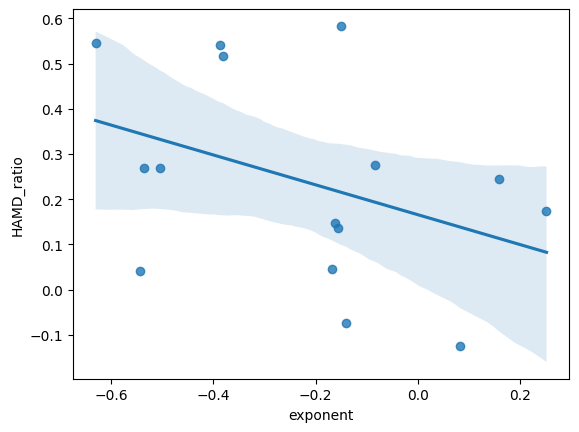

In [26]:
sns.regplot(clin_eeg_diff_df['exponent'], clin_eeg_diff_df['HAMD_ratio'])

In [27]:
corr(clin_eeg_diff_df['exponent'], clin_eeg_diff_df['HAMD_ratio'])

,n,r,CI95%,p-val,BF10,power
pearson,15,-0.391917,"[-0.75, 0.15]",0.148524,0.83,0.314053


### Do responders show different EEG features than non-responders?

In clinical studies (incl. Hill et al, 2020) patients are typically split into two groups, responders (<=50% decrease in symptom severity) and non-responders. Are there differential effects in their EEGs?

Not enough responders to run these analyses

In [28]:
responders_diff_df = clin_eeg_diff_df[clin_eeg_diff_df['HAMD_ratio']>= 0.5]
nonresponders_diff_df = clin_eeg_diff_df[clin_eeg_diff_df['HAMD_ratio']<= 0.5]

<AxesSubplot:xlabel='HAMD_ratio', ylabel='Count'>

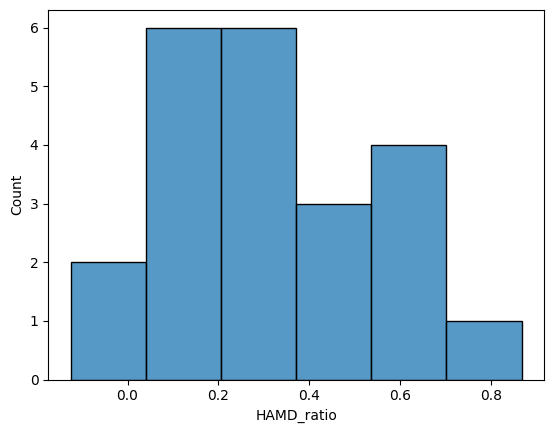

In [29]:
sns.histplot(clin_eeg_diff_df['HAMD_ratio'])

# 3. Does Pre-Treatment EEG predict response to treatment?

In [30]:
FRONTAL_ONLY = True
frontal_channels = ['FP1', 'FPZ', 'FP2', 'AF3', 'AF4', 'F7', 'F5', 'F3', 'F1', 'FZ',
                    'F2', 'F4', 'F6', 'F8', 'FT7', 'FC5', 'FC3', 'FC1', 'FCZ', 'FC2',
                    'FC4', 'FC6', 'FT8', 'C5', 'C3', 'C1', 'CZ', 'C2', 'C4', 'C6']

if FRONTAL_ONLY:
    exp_df_included = exp_df_included[exp_df_included['channel'].isin(frontal_channels)]

In [31]:
# features to include in analysis
features = ['delta_cf', 'delta_bw', 'delta_amp', 'delta_bp', 'theta_cf', 'theta_bw', 'theta_amp',
            'theta_bp', 'alpha_cf', 'alpha_bw', 'alpha_amp', 'alpha_bp', 'offset', 'exponent']

# average across ALL electrodes
exp_df_mean = pd.DataFrame(exp_df_included.groupby(['patient', 'pre_post'], as_index=False)[features].mean())

# Pre ONLY dataframe
eeg_pre_df_mean = pd.DataFrame(exp_df_mean[exp_df_mean['pre_post']=='pre'])

In [32]:
eeg_pre_df_mean.head()

,patient,pre_post,delta_cf,delta_bw,delta_amp,delta_bp,theta_cf,theta_bw,theta_amp,theta_bp,alpha_cf,alpha_bw,alpha_amp,alpha_bp,offset,exponent
1,9,pre,2.008761,1.0,1.428371e-01,-11.315082,5.367909,1.754903,0.516103,-11.469126,9.149521,4.284732,0.967401,-11.435478,-10.937702,1.418123
3,10,pre,2.676020,1.0,8.154322e-07,-12.272586,6.461920,1.070289,0.268704,-12.589385,9.546040,2.796287,0.433698,-12.498315,-11.962090,0.901056
5,18,pre,NaN,NaN,NaN,-11.613646,5.197417,1.215517,0.381131,-11.776708,8.634359,1.499572,1.180806,-11.528292,-11.195960,1.256845
7,22,pre,NaN,NaN,NaN,-11.857298,NaN,NaN,NaN,-12.055416,9.029535,1.660547,1.826599,-11.169985,-11.425692,1.173001
9,25,pre,NaN,NaN,NaN,-11.581348,NaN,NaN,NaN,-12.046017,8.699149,1.511953,1.167282,-11.572502,-11.250514,1.029904


In [33]:
clin_eeg_pre_df = pd.merge(all_clinical, eeg_pre_df_mean, on='patient', how='outer')
# clin_eeg_pre_df.drop([7,8])

/Users/sydneysmith/opt/anaconda3/envs/mst-ect/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='exponent', ylabel='HAMD_ratio'>

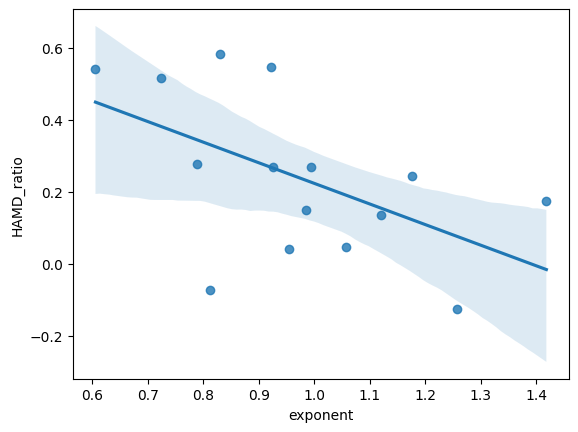

In [34]:
sns.regplot(clin_eeg_pre_df['exponent'], clin_eeg_pre_df['HAMD_ratio'])

In [35]:
corr(clin_eeg_pre_df['exponent'], clin_eeg_pre_df['HAMD_ratio'], method='spearman')

,n,r,CI95%,p-val,power
spearman,15,-0.559428,"[-0.83, -0.07]",0.030134,0.614295


/Users/sydneysmith/opt/anaconda3/envs/mst-ect/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='offset', ylabel='HAMD_ratio'>

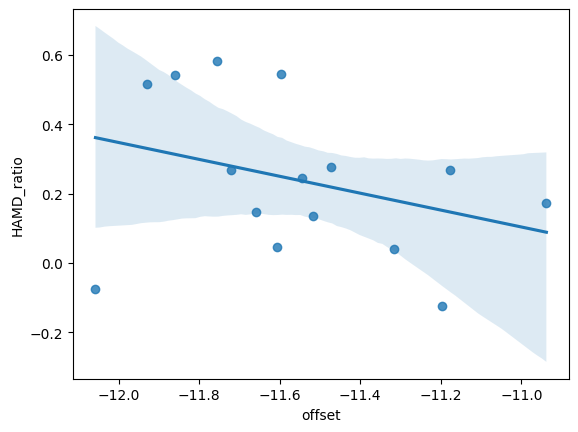

In [36]:
sns.regplot(clin_eeg_pre_df['offset'], clin_eeg_pre_df['HAMD_ratio'])

In [37]:
formula = 'HAMD_ratio ~ exponent + theta_amp'

model = ols(formula, clin_eeg_pre_df).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             HAMD_ratio   R-squared:                       0.130
Model:                            OLS   Adj. R-squared:                 -0.088
Method:                 Least Squares   F-statistic:                    0.5965
Date:                Wed, 03 May 2023   Prob (F-statistic):              0.573
Time:                        12:54:48   Log-Likelihood:                 2.2158
No. Observations:                  11   AIC:                             1.568
Df Residuals:                       8   BIC:                             2.762
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.6166      0.384      1.605      0.1

/Users/sydneysmith/opt/anaconda3/envs/mst-ect/lib/python3.9/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


### Does pre-treatment exponent predict change in exponent?

This was the case in Smith et al, 2022.

/Users/sydneysmith/opt/anaconda3/envs/mst-ect/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 0, 'pre-ECT exponent')

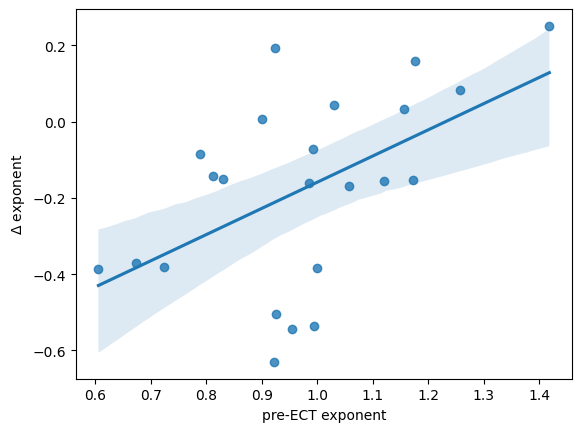

In [38]:
sns.regplot(clin_eeg_pre_df['exponent'], clin_eeg_diff_df['exponent'])
plt.ylabel('$\Delta$ exponent')
plt.xlabel('pre-ECT exponent')

# 4. How does exponent (baseline & change) affect response to treatment?

Does combining the baseline exponent measurement with the patients change in exponent through treatment provide a stronger prediction about treatment response and therapeutic efficacy? This was the case in Smith et al, 2022.

In [39]:
clin_eeg_pre_df.head()

,patient,HAMD_TotalPre,HAMD_TotalPost,n_TxsReceived,HAMD_diff,HAMD_ratio,pre_post,delta_cf,delta_bw,delta_amp,...,theta_cf,theta_bw,theta_amp,theta_bp,alpha_cf,alpha_bw,alpha_amp,alpha_bp,offset,exponent
0,9,23,19.0,24,4.0,0.173913,pre,2.008761,1.0,1.428371e-01,...,5.367909,1.754903,0.516103,-11.469126,9.149521,4.284732,0.967401,-11.435478,-10.937702,1.418123
1,10,28,NaN,18,NaN,NaN,pre,2.676020,1.0,8.154322e-07,...,6.461920,1.070289,0.268704,-12.589385,9.546040,2.796287,0.433698,-12.498315,-11.962090,0.901056
2,18,24,27.0,24,-3.0,-0.125000,pre,NaN,NaN,NaN,...,5.197417,1.215517,0.381131,-11.776708,8.634359,1.499572,1.180806,-11.528292,-11.195960,1.256845
3,20,27,NaN,18,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,22,22,NaN,6,NaN,NaN,pre,NaN,NaN,NaN,...,NaN,NaN,NaN,-12.055416,9.029535,1.660547,1.826599,-11.169985,-11.425692,1.173001


In [40]:
clin_eeg_diff_df.head()

,patient,HAMD_TotalPre,HAMD_TotalPost,n_TxsReceived,HAMD_diff,HAMD_ratio,delta_cf,delta_bw,delta_amp,delta_bp,theta_cf,theta_bw,theta_amp,theta_bp,alpha_cf,alpha_bw,alpha_amp,alpha_bp,offset,exponent
0,9,23,19.0,24,4.0,0.173913,NaN,NaN,NaN,0.391264,0.242568,0.042431,-0.094086,0.225825,-0.185397,2.038570,-0.070322,0.282926,0.445872,0.251241
1,10,28,NaN,18,NaN,NaN,1.67602,-0.633413,-0.474022,0.277103,NaN,NaN,NaN,0.296675,0.125268,1.221717,0.083871,0.387227,0.278691,0.007038
2,18,24,27.0,24,-3.0,-0.125000,NaN,NaN,NaN,0.070714,-1.321810,-0.642431,0.131730,0.314946,-0.121920,0.140817,0.120242,0.132427,0.130354,0.082965
3,20,27,NaN,18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,22,22,NaN,6,NaN,NaN,NaN,NaN,NaN,-0.357518,NaN,NaN,NaN,-0.515141,-0.060471,-2.470790,0.317022,-0.108952,-0.314414,-0.154217


In [41]:
# data cleaning and DF combining 

features = ['patient', 'delta_cf', 'delta_bw', 'delta_amp', 'delta_bp', 'theta_cf', 'theta_bw', 'theta_amp',
            'theta_bp', 'alpha_cf', 'alpha_bw', 'alpha_amp', 'alpha_bp', 'offset', 'exponent']



eeg_diff_df = clin_eeg_diff_df[features].copy().rename(columns={'delta_cf': 'd_delta_cf',
                                                             'delta_bw': 'd_delta_bw', 
                                                             'delta_amp': 'd_delta_amp',
                                                             'delta_bp': 'd_delta_bp',
                                                             'theta_cf': 'd_theta_cf',
                                                             'theta_bw': 'd_theta_bw',
                                                             'theta_amp': 'd_theta_amp',
                                                             'theta_bp': 'd_theta_bp',
                                                             'alpha_cf': 'd_alpha_cf',
                                                             'alpha_bw': 'd_alpha_bw',
                                                             'alpha_amp': 'd_alpha_amp',
                                                             'alpha_bp': 'd_alpha_bp',
                                                             'offset': 'd_offset',
                                                             'exponent': 'd_exponent'})

clin_pre_diff_df = pd.merge(eeg_diff_df, clin_eeg_pre_df, on='patient', how='outer')

In [42]:
formula = 'HAMD_ratio ~ exponent + d_exponent'

model = ols(formula, clin_pre_diff_df).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             HAMD_ratio   R-squared:                       0.298
Model:                            OLS   Adj. R-squared:                  0.181
Method:                 Least Squares   F-statistic:                     2.550
Date:                Wed, 03 May 2023   Prob (F-statistic):              0.119
Time:                        12:54:53   Log-Likelihood:                 4.2062
No. Observations:                  15   AIC:                            -2.412
Df Residuals:                      12   BIC:                           -0.2883
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.7083      0.352      2.012      0.0

/Users/sydneysmith/opt/anaconda3/envs/mst-ect/lib/python3.9/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


In [43]:
formula = 'HAMD_diff ~ exponent + d_exponent'

model = ols(formula, clin_pre_diff_df).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              HAMD_diff   R-squared:                       0.244
Model:                            OLS   Adj. R-squared:                  0.118
Method:                 Least Squares   F-statistic:                     1.934
Date:                Wed, 03 May 2023   Prob (F-statistic):              0.187
Time:                        12:54:53   Log-Likelihood:                -46.269
No. Observations:                  15   AIC:                             98.54
Df Residuals:                      12   BIC:                             100.7
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     17.3102     10.187      1.699      0.1

/Users/sydneysmith/opt/anaconda3/envs/mst-ect/lib/python3.9/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


In [44]:
# Oscillation percentage predicting clinical response???

### Add Delta & Theta osc percentage columns

In [45]:
exp_df_included

,patient,pre_post,channel,delta_cf,delta_bw,delta_amp,delta_bp,theta_cf,theta_bw,theta_amp,theta_bp,alpha_cf,alpha_bw,alpha_amp,alpha_bp,offset,exponent,error,r_squared,exclude
0,9,pre,FP1,NaN,NaN,NaN,-11.283243,6.160561,3.012282,0.722517,-11.315310,9.540913,2.163893,1.129194,-11.300131,-10.910216,1.385597,0.068730,0.981048,False
1,9,pre,FPZ,NaN,NaN,NaN,-11.311451,6.265365,3.086557,0.733975,-11.328971,9.583599,2.081748,1.151045,-11.294941,-10.944674,1.359475,0.069224,0.980534,False
2,9,pre,FP2,NaN,NaN,NaN,-11.285025,NaN,NaN,NaN,-11.403185,8.828444,5.516757,0.979455,-11.320865,-10.902679,1.417495,0.073972,0.978797,False
3,9,pre,AF3,NaN,NaN,NaN,-11.235786,NaN,NaN,NaN,-11.160861,10.032387,8.000000,0.986879,-11.267972,-10.919900,1.315336,0.129817,0.947035,False
4,9,pre,AF4,NaN,NaN,NaN,-11.277961,5.176093,1.263650,0.715413,-11.283006,8.727501,4.945225,0.997578,-11.301249,-10.889718,1.419578,0.071667,0.979583,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2717,191,post,FC1,NaN,NaN,NaN,-12.110455,NaN,NaN,NaN,-12.215916,9.190795,3.505554,1.438309,-11.618953,-11.651782,1.252524,0.090567,0.972185,False
2718,191,post,FCZ,NaN,NaN,NaN,-12.074157,NaN,NaN,NaN,-12.188564,9.095027,3.544203,1.405454,-11.609612,-11.631258,1.257385,0.103540,0.965291,False
2719,191,post,FC2,NaN,NaN,NaN,-12.084908,NaN,NaN,NaN,-12.197249,9.114572,3.623394,1.382153,-11.601712,-11.666210,1.195875,0.090967,0.969700,False
2720,191,post,FC4,NaN,NaN,NaN,-12.044126,NaN,NaN,NaN,-12.137175,8.696469,1.355187,1.555469,-11.527702,-11.577389,1.181892,0.062963,0.984063,False


In [46]:
# Create a new df to find # of channels per person per pre/post that do not have 'nan' 
# (aka that have a delta oscillation)

features = ['patient','pre_post','channel','delta_cf']
exp_df_delta_osc = pd.DataFrame(exp_df_included[features])
exp_df_delta_osc['delta_present'] = exp_df_delta_osc['delta_cf'].notna()
# Create a new df to find # of channels per person per pre/post that do not have 'nan' 

ch_delta = exp_df_delta_osc.groupby(['patient', 'pre_post'])['delta_present'].sum().values
ch_total = exp_df_delta_osc.groupby(['patient', 'pre_post'])['channel'].count().values
ch_delta_perc = ch_delta/ch_total

# Add the delta oscillation percentages to the other df to determine which value corresponds to pre/post

delta_osc_perc = pd.DataFrame(exp_df_delta_osc.groupby(['patient', 'pre_post'], as_index=False)['delta_present'].sum())
delta_osc_perc['ch_delta_perc'] = ch_delta_perc

In [47]:
# same as above but theta

# Create a new df to find # of channels per person per pre/post that do not have 'nan' 
# (aka that have a theta oscillation)

features = ['patient','pre_post','channel','theta_cf']
exp_df_theta_osc = pd.DataFrame(exp_df_included[features])
exp_df_theta_osc['theta_present'] = exp_df_theta_osc['theta_cf'].notna()
# Create a new df to find # of channels per person per pre/post that do not have 'nan' 

ch_theta = exp_df_theta_osc.groupby(['patient', 'pre_post'])['theta_present'].sum().values
ch_total = exp_df_theta_osc.groupby(['patient', 'pre_post'])['channel'].count().values
ch_theta_perc = ch_theta/ch_total

# Add the theta oscillation percentages to the other df to determine which value corresponds to pre/post

theta_osc_perc = pd.DataFrame(exp_df_theta_osc.groupby(['patient', 'pre_post'], as_index=False)['theta_present'].sum())
theta_osc_perc['ch_theta_perc'] = ch_theta_perc

In [48]:
slow_osc_perc = pd.merge(delta_osc_perc, theta_osc_perc, on=['patient', 'pre_post'], how='outer')

In [49]:
slow_osc_perc

,patient,pre_post,delta_present,ch_delta_perc,theta_present,ch_theta_perc
0,9,post,0,0.000000,21,1.000000
1,9,pre,1,0.047619,12,0.571429
2,10,post,1,0.055556,0,0.000000
3,10,pre,1,0.055556,1,0.055556
4,18,post,0,0.000000,1,0.047619
5,18,pre,0,0.000000,15,0.714286
6,22,post,0,0.000000,0,0.000000
7,22,pre,0,0.000000,0,0.000000
8,25,post,0,0.000000,3,0.142857
9,25,pre,0,0.000000,0,0.000000


In [50]:
exp_df_mean_w_percs = pd.merge(exp_df_mean, slow_osc_perc, on=['patient', 'pre_post'], how='outer')

In [51]:
exp_df_mean_w_percs.columns

Index(['patient', 'pre_post', 'delta_cf', 'delta_bw', 'delta_amp', 'delta_bp',
       'theta_cf', 'theta_bw', 'theta_amp', 'theta_bp', 'alpha_cf', 'alpha_bw',
       'alpha_amp', 'alpha_bp', 'offset', 'exponent', 'delta_present',
       'ch_delta_perc', 'theta_present', 'ch_theta_perc'],
      dtype='object')

In [52]:
# Pre/Post Difference dataframe
features = ['delta_cf', 'delta_bw', 'delta_amp', 'delta_bp',
       'theta_cf', 'theta_bw', 'theta_amp', 'theta_bp', 'alpha_cf', 'alpha_bw',
       'alpha_amp', 'alpha_bp', 'offset', 'exponent', 'delta_present',
       'ch_delta_perc', 'theta_present', 'ch_theta_perc']

eeg_diff_df_mean = exp_df_mean_w_percs.groupby(['patient'], as_index=False)[features].diff().dropna(0,how='all').multiply(-1)
eeg_diff_df_mean['patient'] = exp_df_mean_w_percs['patient']

eeg_pre_df_mean = pd.DataFrame(exp_df_mean_w_percs[exp_df_mean_w_percs['pre_post']=='pre'])

/var/folders/96/g2_ml18s7v1cqm0wh8_8n5bh0000gn/T/ipykernel_6067/540046646.py:7: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only
  eeg_diff_df_mean = exp_df_mean_w_percs.groupby(['patient'], as_index=False)[features].diff().dropna(0,how='all').multiply(-1)


In [53]:
clin_eeg_diff_df = pd.merge(all_clinical, eeg_diff_df_mean, on='patient', how='right')
clin_eeg_pre_df = pd.merge(all_clinical, eeg_pre_df_mean, on='patient', how='right')

In [54]:
clin_eeg_pre_df.to_csv('../saved_files_appeal/mst_files/mst_clin_eeg_pre.csv')
clin_eeg_diff_df.to_csv('../saved_files_appeal/mst_files/mst_clin_eeg_diff.csv')